In [1]:
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import preprocess_input

import numpy as np
import cv2
import matplotlib.pyplot as plt
import IPython.display as display
import PIL.Image

%matplotlib inline

# Hyperparameters

In [2]:
image_s = 512 
keep_color = False
content_image_path = "yo_g.jpg"
style_image_path = "colorful.jpg"

alpha = 2e-4 # Content weight
beta = 1 # Style weight
total_variation_weight = 500

# Some functions

In [3]:


def reshape_and_normalize_image(image, image_size = image_s):
    """
    Reshape and normalize the input image
    """
    image = cv2.resize(image, (image_size, image_size))
    image = np.reshape(image, ((1,) + image.shape)) / 255
    #image = tf.keras.applications.vgg19.preprocess_input(image)
    return image


def generate_noise_image(image):
    '''
    Generates noise image with the same dimensions as image
    '''
    noise_image = np.random.randint(low = 0, high = 255, size = image.shape)
    return noise_image / 255
    
    
def clip_0_1(image):
    '''
    Keep pixel values between 0 and 1
    '''
    return tf.clip_by_value(image, clip_value_min = 0.0, clip_value_max = 1.0)


def tensor_to_image(tensor):
    '''
    Transforms input tensor into an image
    '''
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

def save_image(name, image):
    '''
    Saves image to disk
    '''
    image = (image.numpy() * 255).astype(int)
    image_copy = image.copy()
    image[..., 0], image[..., 2] = image_copy[..., 2], image_copy[..., 0]
    
    cv2.imwrite(name, image)

def gram_matrix(input_tensor):
    '''
    Gram matrix to calculate similarity of style (textures)
    '''
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

def rgb_to_grayscale(image):
    image = np.dot(image[..., :3],  [0.2989, 0.5870, 0.1140])
    gray_image = np.zeros(image.shape + (3,))
    
    gray_image[:,:,0] = image
    gray_image[:,:,1] = image
    gray_image[:,:,2] = image
    return gray_image.astype(np.uint8)

def match_color(style_image, content_image, eps = 1e-5):
    '''
    Matches the colour distribution of the target image to that of the source image
    using a linear transform.
    Images are expected to be of form (w,h,c) and float in [0,1].
    Modes are chol, pca or sym for different choices of basis.
    '''
    mu_style = np.mean(style_image, axis = (0,1))
    s = style_image - mu_style
    s = s.transpose(2,0,1).reshape(3,-1)
    # Covariance style
    Cs = np.dot(s, s.T) / s.shape[1] + eps * np.eye(s.shape[0])
    
    mu_content = np.mean( content_image, axis = (0,1) )
    c = content_image - mu_content
    c = c.transpose(2,0,1).reshape(3,-1)
    # Covariance content
    Cc = np.dot(c, c.T) / c.shape[1] + eps * np.eye(c.shape[0])
    
    chol_style = np.linalg.cholesky(Cs)
    chol_content = np.linalg.cholesky(Cc)
    
    style_content = np.dot( np.dot(chol_content, np.linalg.inv(chol_style)), s)
    
    
    matched_img = style_content.reshape(*style_image.transpose(2,0,1).shape).transpose(1,2,0)
    matched_img += mu_content
    matched_img[matched_img>1] = 1
    matched_img[matched_img<0] = 0
    return matched_img


# Define feature extractors

In [4]:
def vgg_layers(layer_names):
    '''
    This model will extract the feature representations of intermediate layers
    '''
    vgg = tf.keras.applications.vgg19.VGG19(
        include_top = False,
        weights = 'imagenet',
        input_shape = (image_s, image_s, 3)
    )
    vgg.trainable = False
    
    # The output of each of the desired layers
    outputs = [vgg.get_layer(name).output for name in layer_names]
    
    model = tf.keras.Model(inputs = vgg.input, outputs = outputs)
    return model

# Extractor class
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers( style_layers + content_layers )
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
        
    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}

content_layers = ["block4_conv2"]

style_layers = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1"
]

extractor = StyleContentModel(style_layers, content_layers)

In [5]:
# Load and normalize content image
content_image = plt.imread(content_image_path)

#if not keep_color:
#    content_image = rgb_to_grayscale(content_image)
content_image = reshape_and_normalize_image(content_image)


# Load and normalize the style image
style_image = plt.imread(style_image_path)
if keep_color:
    style_image = match_color(style_image, content_image[0]) * 255
style_image = reshape_and_normalize_image(style_image)
#plt.imshow(style_image[0])

# Assign noise image as tensorflow variable for gradient descent
noise_image = generate_noise_image(content_image)

noise_image = tf.Variable(noise_image, dtype = tf.float32)


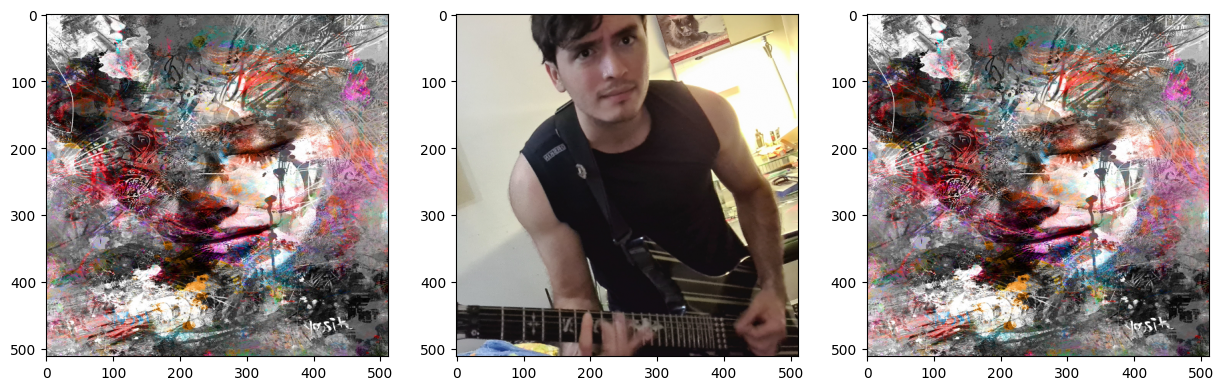

In [6]:
# Plot images
plt.figure(figsize = (15,15))

plt.subplot(1,3,1)
plt.imshow(style_image[0])

plt.subplot(1,3,2)
plt.imshow(content_image[0])

plt.subplot(1,3,3)
plt.imshow(style_image[0])

plt.show()

In [7]:
# Define the content target values ( The output at a certain layer )
content_targets = [ extractor(content_image)['content'][layer] for layer in content_layers ]
style_targets = [ extractor(style_image)['style'][layer] for layer in style_layers]

# Loss functions

In [8]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)

def content_loss(noise_image_features, content_image_features):
    return 0.5 * tf.reduce_sum( (noise_image_features[0] - content_image_features[0]) ** 2 )

def style_loss(noise_image_features, style_image_features):
    style_loss = tf.add_n( [ 0.2 * tf.reduce_mean( (output - target) ** 2 ) for output, target
                                 in zip(noise_image_features, style_image_features) ])
    
    return style_loss
    

# Optimize for style and content

In [9]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as grad:
        outputs = extractor(image)
        
        style_loss_value = style_loss([ outputs['style'][layer] for layer in style_layers],
                                      style_targets)
        
        content_loss_value = content_loss([ outputs['content'][layer] for layer in content_layers ],
                                          content_targets)
        
        total_loss = alpha * content_loss_value + beta * style_loss_value
        total_loss += total_variation_weight * tf.image.total_variation(image)
        
        
    gradients = grad.gradient(total_loss, image)
    optimizer.apply_gradients( [(gradients, image)] )
    image.assign(clip_0_1(image))
        

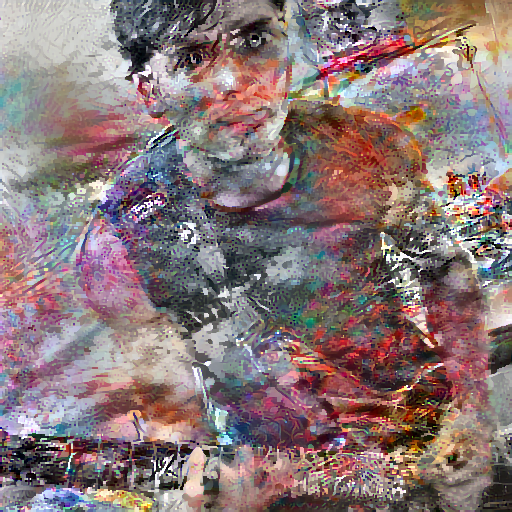

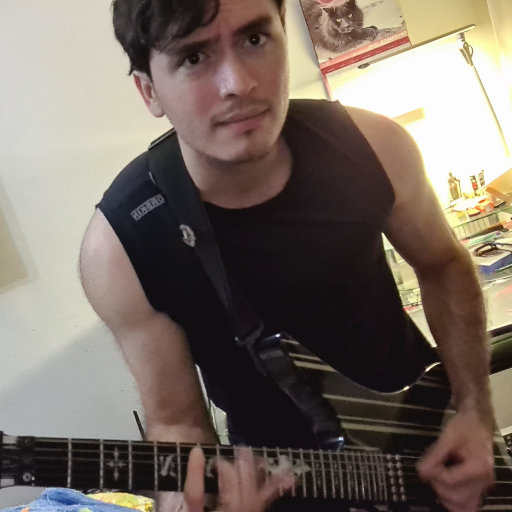

In [10]:
epochs = 200
steps_per_epoch = 100

for epoch in range(epochs):
    print(f"Epoch: {epoch}")
    
    for step in range(steps_per_epoch):
        train_step(noise_image)
    display.clear_output(wait=True)
    display.display(tensor_to_image(noise_image))
    display.display(tensor_to_image(content_image))
    save_image(f'Yo/yo_gif/epoch_{epoch}.png', noise_image[0])
    

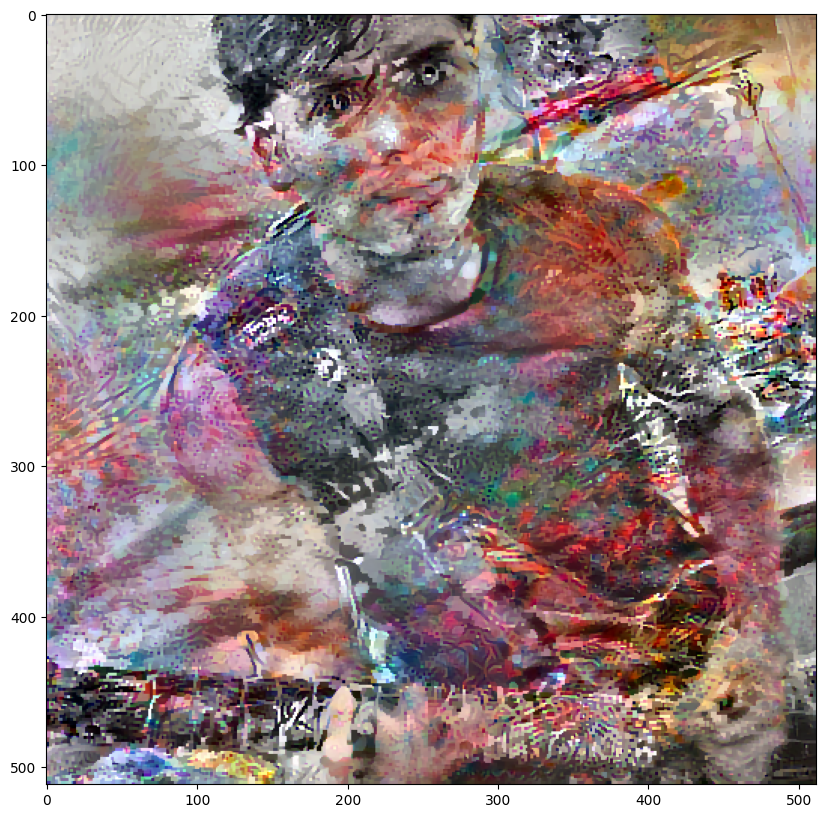

In [11]:
plt.figure(figsize = (10,10))
plt.imshow(noise_image[0])
plt.show()

In [12]:
save_image('campero_color.jpg', noise_image[0])

# Create and save gif

In [20]:
from PIL import Image

images = []

for epoch in range(200):
    image = plt.imread(f'Yo/yo_gif/epoch_{epoch}.png') * 255
    image = image.astype(np.uint8)
    
    image = Image.fromarray( image.astype(np.uint8) )
    images.append(image)

In [21]:
images[0].save('campero_color.gif', save_all = True, append_images = images[1:],
               optimize = False, duration = 15, loop = 1)